<a href="https://colab.research.google.com/github/hkaragah/risk_reliability/blob/main/PSHA_Two_Rupture_Boore1997GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PSHA: Two Rupture Scenario Using Boore et al. 1997 GMM

## 1. Setting-up Working Directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

working_dir = "/content/drive/MyDrive/Colab Notebooks/risk_reliability"
if not os.path.exists(working_dir):
  os.makedirs(working_dir)
os.chdir(working_dir)

print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/Colab Notebooks/risk_reliability


In [3]:
!pwd

/content/drive/MyDrive/Colab Notebooks/risk_reliability


In [4]:
!ls

 BART.ipynb			       'Monte Carlo Simulation-Roulette Simulator.ipynb'
 Boore_et_al_1997.csv		       'Monte Carlo: Tests.ipynb'
 Boore_et_al_1997.gsheet	       'Prior and Posterior.ipynb'
 Gutenberg_Richter_Distribution.ipynb  'PSHA-One Rupture_Boore1997GMM.ipynb'
'Kolmogorov-Smirnov test.ipynb'         PSHA-Two_Rupture_Boore1997GMM.ipynb
'Monte Carlo_Resampling.ipynb'	        Untitled0.ipynb


## 2. Import Dependencies

In [5]:
import pandas as pd
from math import sqrt, log, exp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

## 3. Define Site and Ruptures

1. __Rupture 1 ($rup_1$)__

  The $rup_1$ is defined as a strike-slip fault that produces 6.5 magnitudes earthquakes at a rate of 0.01 per year:

  * $M=6.5$
  * $\lambda=0.01$

2. __Rupture 2 ($rup_2$)__

  The $rup_2$ has the following characteristics:

  * $M=7.5$
  * $\lambda=0.002$

3. __Site__

  The average shear wave velocity at the site is 500 m/s over a depth of 30 meters and its distance from $rup_1$ and $rup_2$ is as follows:

  * $R_1=10 \ km$
  * $R_2=10 \ km$
  * $V_{S,30}=500 \ m/s$




In [32]:
class rupture():

    def __init__(self, rup_type:str, magnitude:float, rate:float):
        self.rup_type = rup_type
        self.magnitude = magnitude
        self.rate = rate

    def __str__(self) -> str:
        return f"Type: {self.rup_type}, Magnitude: {self.magnitude}, Rate: {self.rate}"



class site():

    def __init__(self, shear_velocity_m_sec:float):
        self.shear_velocity = shear_velocity_m_sec # Vs
        self.rup = {}

    def add_rup(self, rupId:str, rup:rupture, dist_km:float):
        self.rup[rupId] = {'rup':rup, 'dist': dist_km}

    def __str__(self) -> str:
        rup_str = "\n".join([f"{id} -> {rup['rup']}, Distance: {rup['dist']}" for id, rup in self.rup.items()])
        return f"Site: Vs {self.shear_velocity}\nRuptures:\n{rup_str if rup_str else 'None'}"



In [33]:
rup1 = rupture("strike-slip", 6.5, 0.01)
rup2 = rupture("strike-slip", 7.5, 0.002)
site1 = site(500)

dist = 10 # km
for id, rup in {"rup1": rup1, "rup2": rup2}.items():
  site1.add_rup(id, rup, dist)

print(site1)

Site: Vs 500
Ruptures:
rup1 -> Type: strike-slip, Magnitude: 6.5, Rate: 0.01, Distance: 10
rup2 -> Type: strike-slip, Magnitude: 7.5, Rate: 0.002, Distance: 10


## 4. Boore et al. (1997) Ground-Motion Model (GMM)

1- __Reference__

David M. Boore, William B. Joyner, and Thomas E. Fumal, 1997, Equations for Estimating Horizontal Response Spectra and Peak Acceleration from Western North American Earethquakes: A Summary of recent Work, Seismological Research Letters, Vol. 68, No. 1, 128-153.

2- __Estimated physical parameter__

  - Peak ground acceleration (Horizontal)
  - Spectral acceleration (h=5%, T=0.1 to 2 sec) (Horizontal)



3- __Used strong motion data__

  - Area: Western North America
  - Type of earthquake: Shallow earthquake (which the fault rupture lies mainly above a depth of  20km)
  - Period: 1940 – 1992 years
  - Number of events: 19
  - Number of records: 271
  - Magnitude: 5.2 – 7.4
  - Epicentral distance: 0 – 118 km

4- __Style of faulting__

  - Strike-slip
  - Reverse-slip
  - Mechanism is not specified

5- __Ground condition__

Classified by the average S-wave velocity over 30 m from ground surface

6- __Definition of magnitude__

Moment magnitude

7- __Definition of source distance__

Closest horizontal distance to a point on the earth's surface that lies directly above the rupture.

8- __Definition of horizontal component__

Random horizontal component

9- __Applicability written in the paper__

The equations are to be used magnitude 5.5 - 7.5 and distance no greater than 80 km.

10- __Empirical attenuation formula__

$$\ln Y = b_1 + b_2(M-6) + b_3(M-6)^2 + b_5 \ln r + b_V \ln \frac{V_S}{V_A}$$

* $r=\sqrt{r_{jb}^2 + h^2}$

* $b_1 =
\begin{cases}
b_{1SS} &\text{for strike-slip earquake s}\\
b_{1RV} &\text{for reverse-slip earthquake s}\\
b_{1ALL} &\text{if mechanism not specified}
\end{cases}$

* $Y$: peak horizontal acceleration or pseudo acceleration response (g)

* $M$: moment magnitude

* $r_{jb}$: closest horizontal distance to the surface projection of the rupture plane (km)

* $V_S$: average shear wave velocity to 30 m (m/sec)

Standard Error:
* $\sigma_{\ln Y}^2 = \sigma_Y^2 + \sigma_e^2$
* $\sigma_{\ln Y}$: one-sigma value of the natural logarithm of the ground-motion value
* $\sigma_e^2$: earthquake-to-earthquake component of variability
* $\sigma_r^2$: all other components of variability
* $\sigma_r^2 = \sigma_1^2 + \sigma_c^2$
* $\sigma_1^2$: variance from the first stage of regression
* $\sigma_c^2$: correction needed to give the variance corresponding to the randomly-oriented horizontal component

<a href="https://iisee.kenken.go.jp/eqflow/reference/1_2.htm">Boore et al 1997 coefficients</a>

In [9]:
class Boore1997:

    # Boore et al. 1997 coefficients
    boore = pd.read_csv("Boore_et_al_1997.csv", header=0, index_col="Period")
    boore.drop([0],axis=0,inplace=True)

    def compute_median_ground_motion(self, shear_velocity_m_sec:float, rup:rupture, dist_km:float):

        df = pd.DataFrame(columns=['Y', 'slnY'], index=self.boore.index)

        rup_type = rup.rup_type
        M = rup.magnitude
        r_jb = dist_km
        V_S = shear_velocity_m_sec

        r = np.sqrt(r_jb**2 + self.boore['h']**2)

        b2 = self.boore['B2']
        b3 = self.boore['B3']
        b5 = self.boore['B5']
        bv = self.boore['BV']
        V_A = self.boore['VA']

        if rup_type.lower() == 'strike-slip':
            b1 = self.boore['B1SS']
        elif rup_type.lower() == 'reverse-slip':
            b1 = self.boore['B1RV']
        else:
            b1 = self.boore['B1ALL']

        df['Y'] = np.exp(b1 + b2*(M-6) + b3*(M-6)**2 + b5*np.log(r) + bv*np.log(V_S/V_A))
        df['slnY'] = self.boore['slnY']

        return df

## 5. Computing Median and Standard Deviation of Spectral Acceleration

In [14]:

gmm = Boore1997()

medians = []
keys = []
for id, rup in site1.rup.items():
    medians.append(gmm.compute_median_ground_motion(site1.shear_velocity, rup['rup'], rup['dist']))
    keys.append(id)

site1_medians = pd.concat(medians, keys=keys, names=['rupture'])
site1_medians = site1_medians.reset_index(level='rupture')  # Move 'Category' from index to a column

site1_medians.head()

,rupture,Y,slnY
Period,,,
0.10,rup1,0.444860,0.479
0.11,rup1,0.473107,0.481
0.12,rup1,0.494142,0.485
0.13,rup1,0.511128,0.486
0.14,rup1,0.526031,0.489


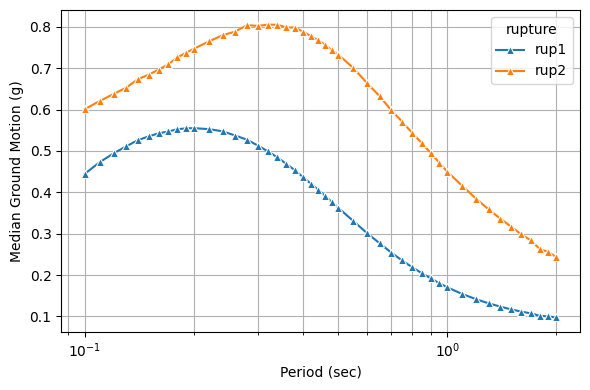

In [167]:
plt.figure(figsize=(6,4))

sns.lineplot(data=site1_medians, x='Period', y='Y', hue='rupture', marker='^')
plt.xscale('log')
plt.xlabel('Period (sec)')
plt.ylabel('Median Ground Motion (g)')
plt.grid(which='both')
plt.tight_layout()
plt.show()

## 6. Computing Annual Rate of Exceedance for SA(1s)

In [146]:
def compute_probability_of_exceedance(median_ground_motions:pd.DataFrame, rupId:str, spectral_acceleration):
    median_ground_motion = median_ground_motions[site1_medians.rupture==rupId].loc[period, 'Y']
    standard_deviation = median_ground_motions[site1_medians.rupture==rupId].loc[period, 'slnY']
    return 1 - norm.cdf(np.log(spectral_acceleration), loc=np.log(median_ground_motion), scale=standard_deviation)

def compute_annual_rate_of_exceedance(median_ground_motions:pd.DataFrame, rupId:str, spectral_acceleration, rate):
    probability_of_exceedance = compute_probability_of_exceedance(median_ground_motions, rupId, spectral_acceleration)
    return probability_of_exceedance * rate

In [148]:
spectral_acceleration = np.linspace(5e-2, 2, 100) # Specteral Acceleration SA(1 s) [g]
period = 1.0 # sec, SA(1s)

rate_of_exceedance = pd.DataFrame()
total_annual_rate_of_exceedance = np.zeros(len(spectral_acceleration))
for id in site1.rup.keys():

    annual_rate_of_exceedance = compute_annual_rate_of_exceedance(site1_medians, id, spectral_acceleration, site1.rup[id]['rup'].rate)

    total_annual_rate_of_exceedance += annual_rate_of_exceedance

    data = {'rupture': id, 'spectral_acceleration': spectral_acceleration, 'annual_rate_of_exceedance': annual_rate_of_exceedance}
    rate_of_exceedance = pd.concat([rate_of_exceedance, pd.DataFrame(data)], axis=0)

rate_of_exceedance = pd.concat([rate_of_exceedance, pd.DataFrame({'rupture': 'total hazard', 'spectral_acceleration': spectral_acceleration, 'annual_rate_of_exceedance': total_annual_rate_of_exceedance})], axis=0)

rate_of_exceedance.head()

,rupture,spectral_acceleration,annual_rate_of_exceedance
0,rup1,0.050000,0.009771
1,rup1,0.069697,0.009273
2,rup1,0.089394,0.008532
3,rup1,0.109091,0.007658
4,rup1,0.128788,0.006752


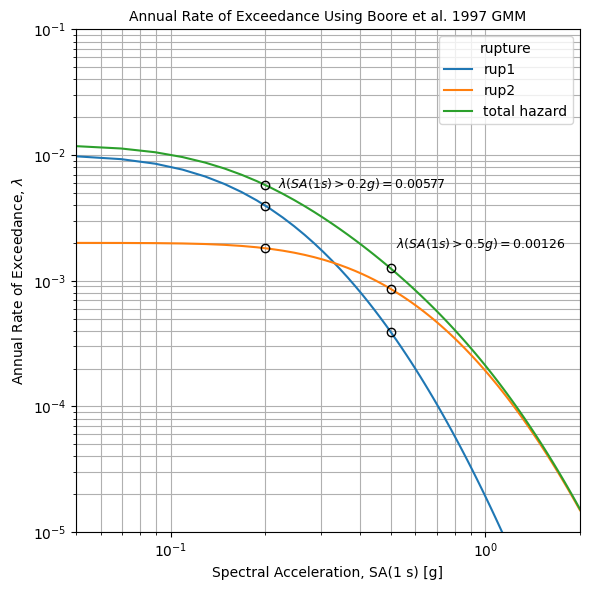

In [162]:
def compute_rate(target_sa, rupId):
    if rupId == 'total hazard':
        return sum([compute_annual_rate_of_exceedance(site1_medians, id, target_sa, site1.rup[id]['rup'].rate) for id in site1.rup.keys()])
    else:
        return compute_annual_rate_of_exceedance(site1_medians, rupId, target_sa, site1.rup[rupId]['rup'].rate)


def annotate_sa(target_sa:float, rupId:str, show_rate:bool=False):
    rate = compute_rate(target_sa, rupId)
    plt.plot(target_sa, rate, marker='o',markerfacecolor='none', markeredgecolor='black')
    if show_rate:
        plt.annotate(fr"$\lambda (SA(1s)>{target_sa}g) = {rate:.5f}$",
                     xy=(target_sa+2e-2, rate+1e-3), xycoords='data', va='top', ha='left', fontsize=9)


plt.figure(figsize=(6, 6))
sns.lineplot(data=rate_of_exceedance, x='spectral_acceleration', y='annual_rate_of_exceedance', hue='rupture', linestyle='-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Spectral Acceleration, SA(1 s) [g]')
plt.ylabel('Annual Rate of Exceedance, $\lambda$')
plt.xlim(min(spectral_acceleration), max(spectral_acceleration))
plt.ylim(1e-5, 0.1)
plt.title('Annual Rate of Exceedance Using Boore et al. 1997 GMM', fontsize=10)

for sa in [0.2, 0.5]:
    for rupId in rate_of_exceedance.rupture.unique():
        if rupId == 'total hazard':
            annotate_sa(sa, rupId, show_rate=True)
        else:
            annotate_sa(sa, rupId)


plt.grid(which='both')
plt.tight_layout()
plt.show()